<a href="https://colab.research.google.com/github/JimmyPlaysViolin/AI4Gov-UAV/blob/main/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyflyt

In [2]:
import gymnasium as gym
import numpy as np
from PyFlyt.core import Aviary
import PyFlyt.gym_envs
import matplotlib.pyplot as plt


In [3]:
!pip3 install numpy==1.25.2

In [4]:
!pip3 install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [5]:
from stable_baselines3 import PPO #the RL model used

In [6]:
from stable_baselines3.common.evaluation import evaluate_policy

In [7]:
#sensor noise environment
class NoisyObservationEnv(gym.Env):
    def __init__(self, env, noise_scale=0.1):
        super().__init__()
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.noise_scale = noise_scale

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        obs = obs + np.random.normal(0, self.noise_scale, size=obs.shape) # Add gaussian noise to sensor readings
        return obs, reward, terminated, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [8]:
#wind environment
class WindDisturbanceEnv(gym.Env):
    def __init__(self, env, force_scale=1.0, disturb_prob=0.2):
        super().__init__()
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.force_scale = force_scale
        self.disturb_prob = disturb_prob

    def step(self, action):
        # Simulates wind pushing in a random direction
        if np.random.rand() < self.disturb_prob:
            action = self.action_space.sample()  # chooses a random action for the drone to complete/ simulates the jerking of drones in wind
        return self.env.step(action)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [ ]:
#creating models across different levels of wind
wind_levels = [0.0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.3]
performance = []

for noise in wind_levels:
    print(f"\nTraining with noise level: {noise}")

    # create and wrap environment in varying levels
    base_env = gym.make("PyFlyt/QuadX-Hover-v4", render_mode=None)
    noisy_env = WindDisturbanceEnv(base_env, disturb_prob = noise)

    # training agent
    model = PPO("MlpPolicy", noisy_env, verbose=0)
    model.learn(total_timesteps=200000)
    model.save(f"ppo_noise_{noise:.2f}a")



Training with noise level: 0.1
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
                             
        

In [ ]:
#creating models across different types of noise (wind only, sensor only, sensor+wind)

for i in range(3):
    base_env = gym.make("PyFlyt/QuadX-Hover-v4", render_mode=None)
    if i == 0:
        noisy_env = NoisyObservationEnv(base_env, noise_scale = 0.15)
        model = PPO("MlpPolicy", noisy_env, verbose=0)
        model.learn(total_timesteps=200000)
        model.save(f"ppo_noiseonly_0.15")
    elif i ==1:
        noisy_env = NoisyObservationEnv(base_env, noise_scale = 0.15)
        combined_env = WindDisturbanceEnv(noisy_env, disturb_prob = 0.15)
        model = PPO("MlpPolicy", combined_env, verbose=0)
        model.learn(total_timesteps=200000)
        model.save(f"ppo_both_0.15")
    else:
        wind_env = WindDisturbanceEnv(base_env, disturb_prob = 0.15)
        model = PPO("MlpPolicy", wind_env, verbose=0)
        model.learn(total_timesteps=200000)
        model.save(f"ppo_wind_0.15")







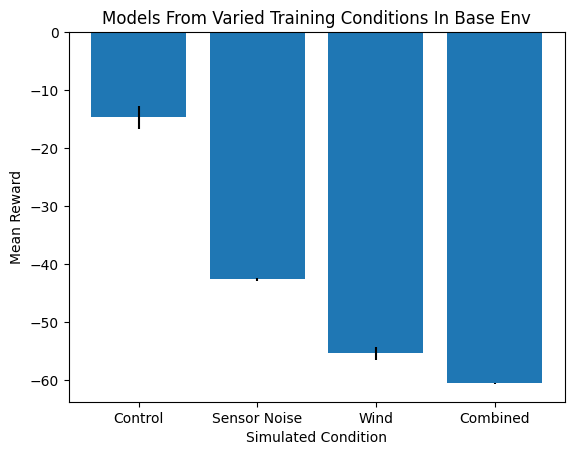

In [ ]:
# evaluating different models in base environment
mean_rewards = []
std_rewards = []
models = ['Control', 'Sensor Noise', 'Wind', 'Combined']
env = gym.make("PyFlyt/QuadX-Hover-v4", render_mode=None)
windy_env = WindDisturbanceEnv(env, disturb_prob= .15)
sensor_noise_env = NoisyObservationEnv(env, noise_scale = 0.15)
combined_env = WindDisturbanceEnv(sensor_noise_env, disturb_prob= .15)

# model trained without noisee (control)
model = PPO.load("ppo_noise_0.00", env=env)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
mean_rewards.append(mean_reward)
std_rewards.append(std_reward)

# model trained in noisy environment
model = PPO.load("ppo_noiseonly_0.15", env=env)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
mean_rewards.append(mean_reward)
std_rewards.append(std_reward)

# model trained in windy
model = PPO.load("ppo_wind_0.15", env=env)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
mean_rewards.append(mean_reward)
std_rewards.append(std_reward)

# model trained in both
model = PPO.load("ppo_both_0.15", env=env)
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
mean_rewards.append(mean_reward)
std_rewards.append(std_reward)

plt.bar(models, mean_rewards, yerr = std_rewards)

plt.title('Models From Varied Training Conditions In Base Env')
plt.xlabel("Simulated Condition")
plt.ylabel('Mean Reward')
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

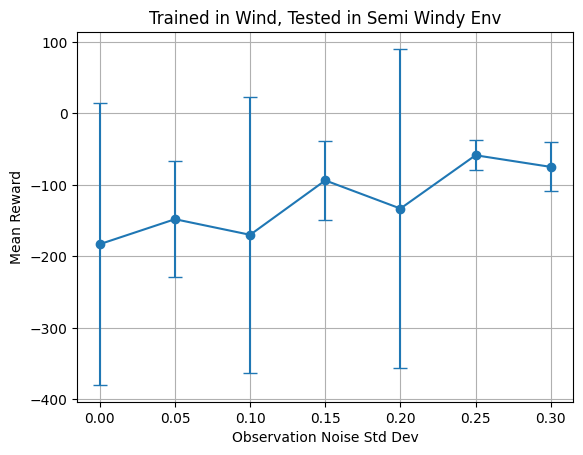

In [18]:
#testing each of models
#this can be easily modified to change what environment to test in
wind_levels = [0.0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30]

mean_rewards = []
std_rewards = []
for level in wind_levels:
    base_env = gym.make("PyFlyt/QuadX-Hover-v4", render_mode=None)
    env = WindDisturbanceEnv(base_env, disturb_prob = .3) # currently testing in a wind environment at noise level = 0.3, but can be changed
    model = PPO.load(f"ppo_noise_{level:.2f}", env=env) # saves the model, can be loaded later
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20) # evaluated the model and gets values
    mean_rewards.append(mean_reward)
    std_rewards.append(std_reward)

print(mean_rewards)
plt.errorbar(wind_levels, mean_rewards, yerr=std_rewards, fmt='o-', capsize=5)

# plt.plot(wind_levels, mean_rewards, marker='o')
plt.title("Trained in Wind, Tested in Semi Windy Env")
plt.xlabel("Observation Noise Std Dev")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.show()



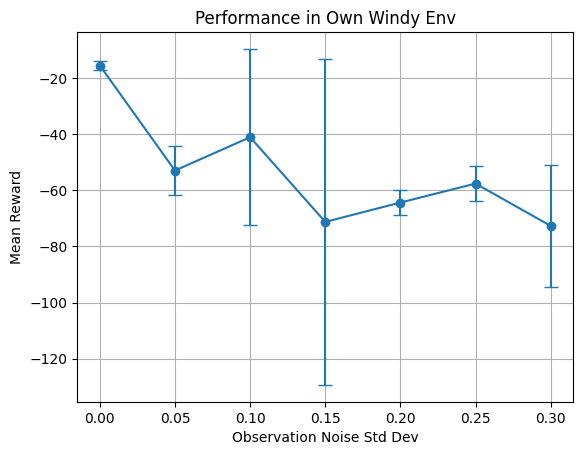

In [12]:
#testing each of models in their own environment
wind_levels = [0.0, 0.05, 0.1, 0.15, 0.20, 0.25, 0.30]

mean_rewards = []
std_rewards = []
for level in wind_levels:
    base_env = gym.make("PyFlyt/QuadX-Hover-v4", render_mode=None)
    env = WindDisturbanceEnv(base_env, disturb_prob = level)
    model = PPO.load(f"ppo_noise_{level:.2f}", env=env)
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
    mean_rewards.append(mean_reward)
    std_rewards.append(std_reward)

print(mean_rewards)
plt.errorbar(wind_levels, mean_rewards, yerr=std_rewards, fmt='o-', capsize=5)

# plt.plot(wind_levels, mean_rewards, marker='o')
plt.title("Performance in Own Windy Env")
plt.xlabel("Observation Noise Std Dev")
plt.ylabel("Mean Reward")
plt.grid(True)
plt.show()



In [13]:
#to make a gif image of a certain model
env = gym.make("PyFlyt/QuadX-Hover-v4", render_mode="rgb_array")

import imageio

model = PPO.load("ppo_noise_0.10", env=env)
obs, info = env.reset()
frames = []

for _ in range(2000):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)

    frame = env.render()
    frames.append(frame)

    if terminated or truncated:
        break

env.close()

imageio.mimsave("ppo_flight_0.10_1.gif", frames, fps=30)


/usr/local/lib/python3.11/dist-packages/gymnasium/utils/passive_env_checker.py:283: UserWarning: WARN: RGB-array rendering should return a numpy array in which the last axis has three dimensions, got 4
  logger.warn(
/usr/local/lib/python3.11/dist-packages/imageio/plugins/pillow.py:409: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(
